In [ ]:
!pip install "preliz[full,notebook]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm
import preliz as pz

**What is the average number of people who contract influenza in Travis County per week?**

CDC estimates that flu has resulted in 41 million illnesses, 710,000 hospitalizations and 51,000 deaths annually between 2010 and 2023. It is important to be able to predict statistics about the virus so that hospitals can be better prepared to combat this disease in the coming years.

**Data**

This is data from the Texas Respiratory Virus Surveillance Report by the DSHS (Department of State and Health Services)

I graphed it as a histogram. You can see how the case numbers dropped towards the end to indicate the conclusion of "flu season" which is from November to April.

**Data Analyzation**

Most of the cases are centered around 2,000, while the average is around 2,500. The graph of the data has a positive skew.

In [ ]:
FluData_url = 'https://raw.githubusercontent.com/rithisenthil/DSF_Submission_Files/refs/heads/main/U3ProjData%20-%20Sheet1%20(1).csv'
FluData1 = pd.read_csv(FluData_url).to_numpy()
FluData = np.zeros(50)

In [ ]:
len(FluData)

50

(array([ 6., 11., 11.,  5.,  2.,  6.,  5.,  1.,  2.,  1.]),
 array([ 619. , 1057.1, 1495.2, 1933.3, 2371.4, 2809.5, 3247.6, 3685.7,
        4123.8, 4561.9, 5000. ]),
 <BarContainer object of 10 artists>)

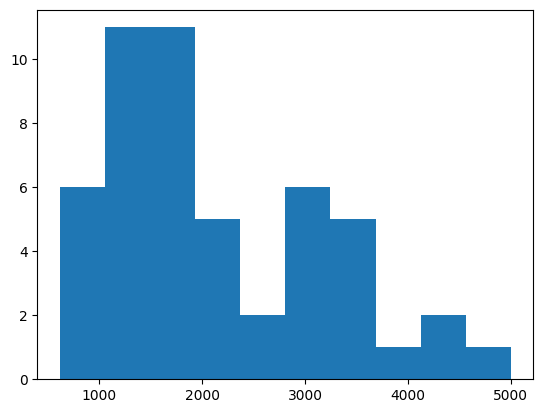

In [ ]:
for i in range(0, len(FluData)):
  FluData[i] = FluData1[i][0]

plt.hist(FluData)

**Model 1: Gamma Prior, Poisson Likelihood**

For my first model, I used a pairing of the gamma distribution as my prior, and the Poisson distribution as my likelihood. This made sense to me because the Poisson distribution models the number of "sucesses" in a period of time which fits my goal of predicting the number of flu cases per week.


<Axes: >

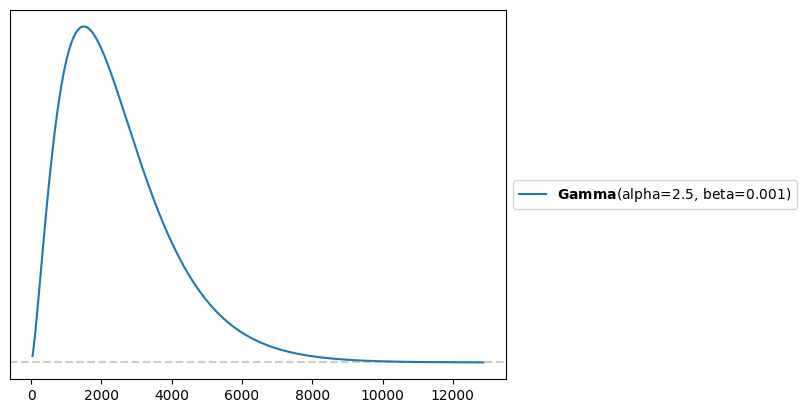

In [ ]:
pz.Gamma(alpha=2.5, beta=.001).plot_pdf()

Output()

Output()

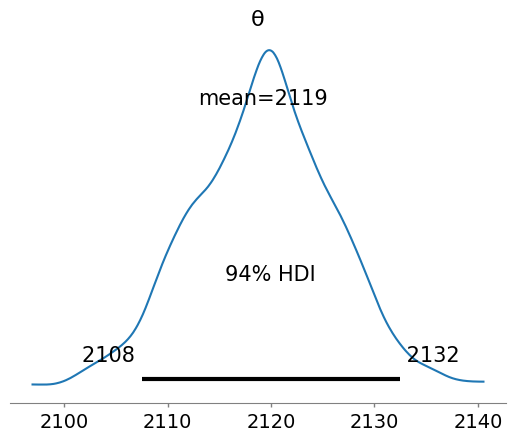

In [ ]:
with pm.Model() as Flu_cases_model_Poisson:

  #Prior
  θ = pm.Gamma('θ' , alpha = 2.5 , beta = 0.001)

  #I used the Poisson distribution
  y = pm.Poisson('y', mu = θ , observed = FluData)

  #sample from the posterior
  idata_FluData_p = pm.sample()

  az.plot_posterior(idata_FluData_p)

Output()

<Axes: xlabel='y'>

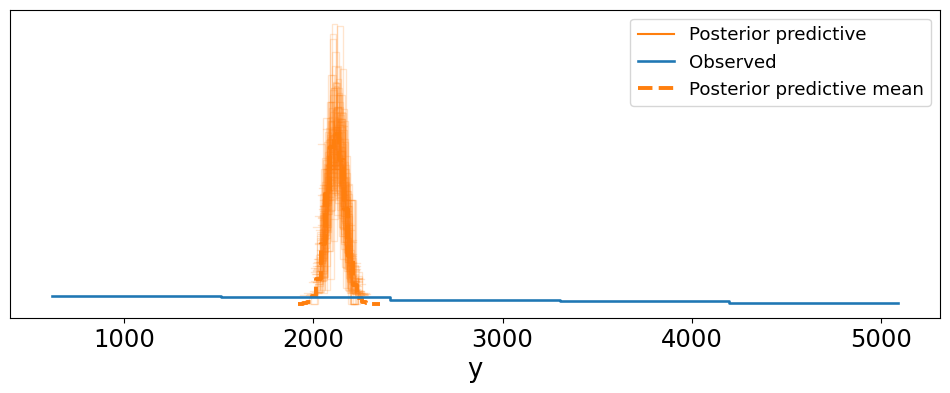

In [ ]:
pm.sample_posterior_predictive(idata_FluData_p, model= Flu_cases_model_Poisson, extend_inferencedata=True)
az.plot_ppc(idata_FluData_p, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

**Analyzation**

As you can see, this model did not work as planned. The PPC is very very off. This is because the Poisson distribution is best used to model discrete data. The number of flu cases may seem discrete, but since the numbers are all very similar and there is so much data, they are continuous. Due to this, my model was unable to process it well resulting in the above PPC.

**___________________________________________________________________________________________________________________**

**Model 2: Gamma and Half-Normal Priors, Normal Likelihood**

I used the Gamma and Half-Normal distributions as my priors because I was using the Normal distribution and it requires 2 priors. I used the Normal distributions for my likelihood because it serves as a sort of base for me to adjust my likelihood accordingly.

<Axes: >

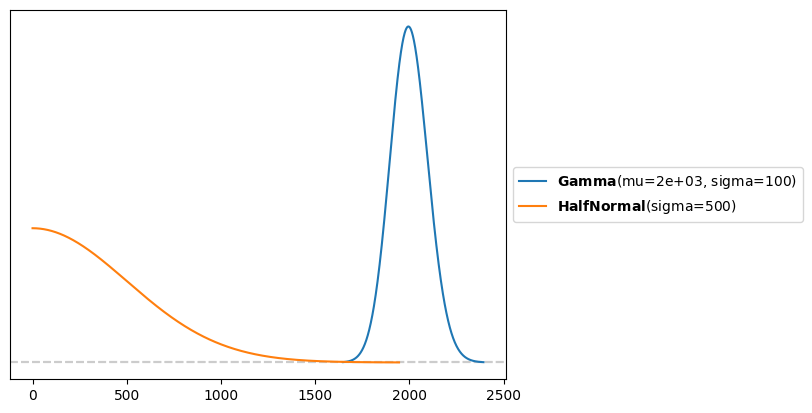

In [ ]:
pz.Gamma(mu=2000, sigma=100).plot_pdf()
pz.HalfNormal(sigma=500).plot_pdf()

Output()

Output()

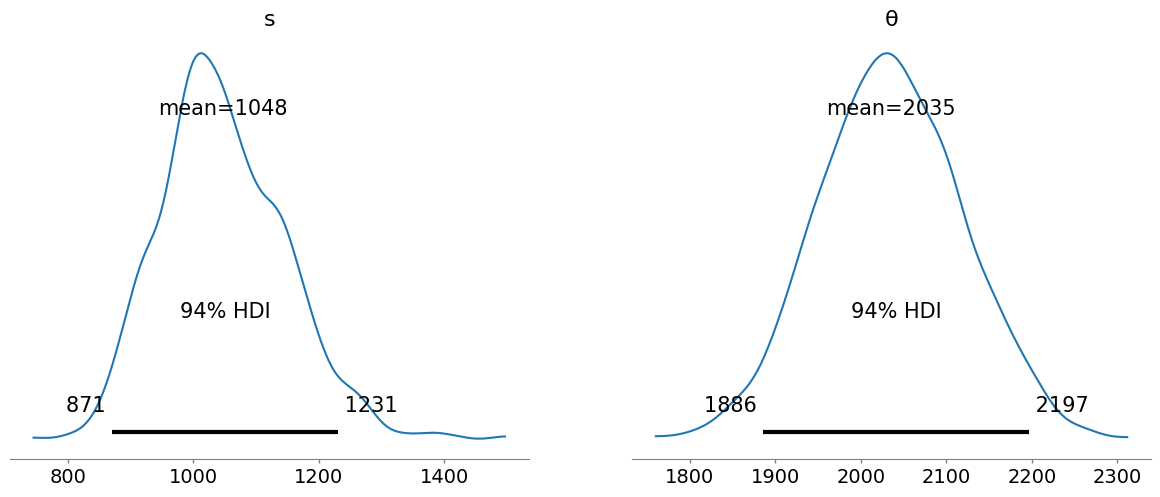

In [ ]:
with pm.Model() as Flu_cases_model_Normal:

  #Prior data
  θ = pm.Gamma('θ' , mu = 2000 , sigma = 100)

  s = pm.HalfNormal('s',sigma=500)

  #I used the Normal distribution
  y = pm.Normal('y', mu = θ , sigma = s, observed = FluData)

  #sample from the posterior
  idata_FluData_n = pm.sample()

  az.plot_posterior(idata_FluData_n)

Output()

<Axes: xlabel='y'>

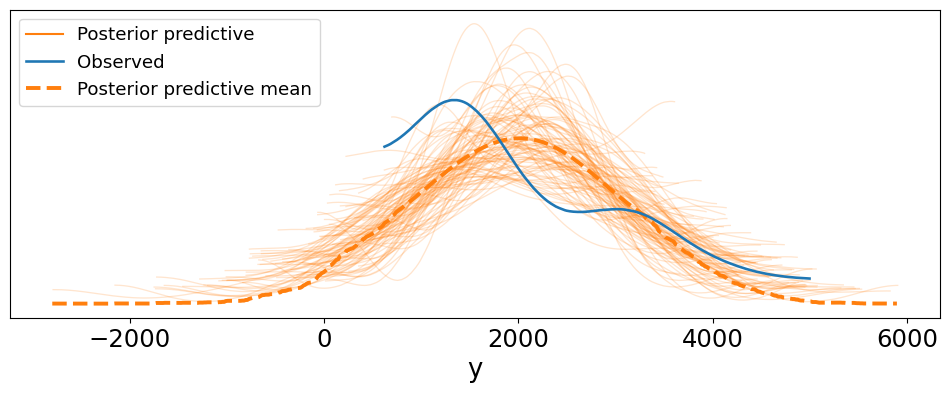

In [ ]:
pm.sample_posterior_predictive(idata_FluData_n, model= Flu_cases_model_Normal, extend_inferencedata=True)
az.plot_ppc(idata_FluData_n, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

**Analyzation**

You can see that this model is very off. This is because the normal distribution does not have a shape that is similar to the data and priors. This is fine though, because they whole point of this variation was to serve as a baseline for adjustments.

**_________________________________________________________**

**Model 3: Gamma and Half Normal Priors, Gamma Likelihood**

For this model, I used the same priors as above because they do the best job as a pair to mimic the shape of my data. I used the Gamma distribution as my likelihood because it essentially models the same process as the Poisson but it is built for continuous data.

<Axes: >

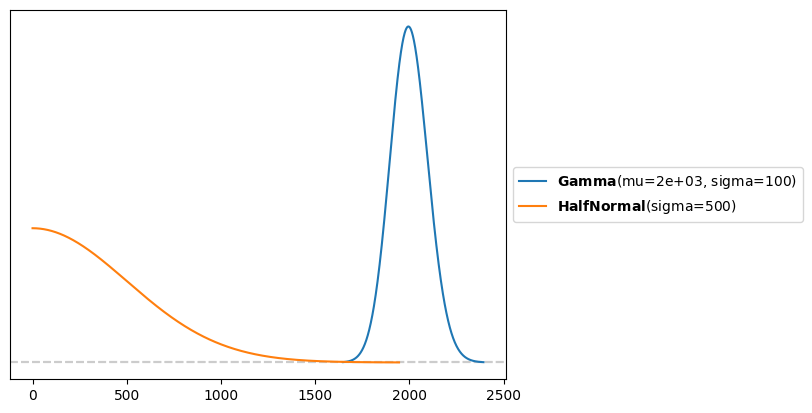

In [ ]:
pz.Gamma(mu=2000, sigma=100).plot_pdf()
pz.HalfNormal(sigma=500).plot_pdf()

Output()

Output()

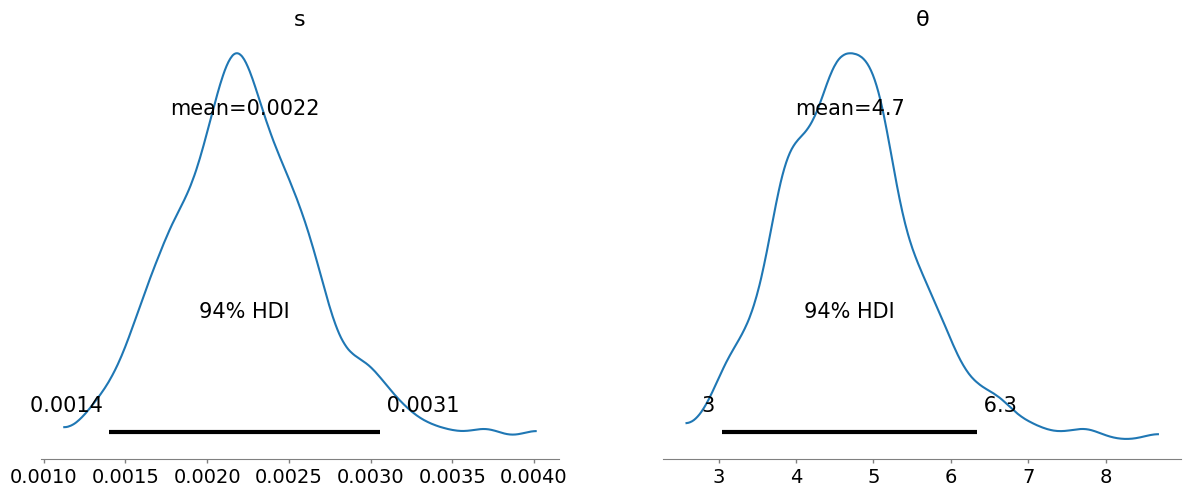

In [ ]:
with pm.Model() as Flu_cases_model_Gamma:

  #Prior data
  θ = pm.Gamma('θ' , alpha = 2.5 , beta = 0.001)
  s = pm.HalfNormal('s',sigma=500)

  #I used the Gamma distribution
  y = pm.Gamma('y', alpha= θ , beta= s, observed = FluData)

  #sample from the posterior
  idata_FluData_g = pm.sample()

  az.plot_posterior(idata_FluData_g)

Output()

<Axes: xlabel='y'>

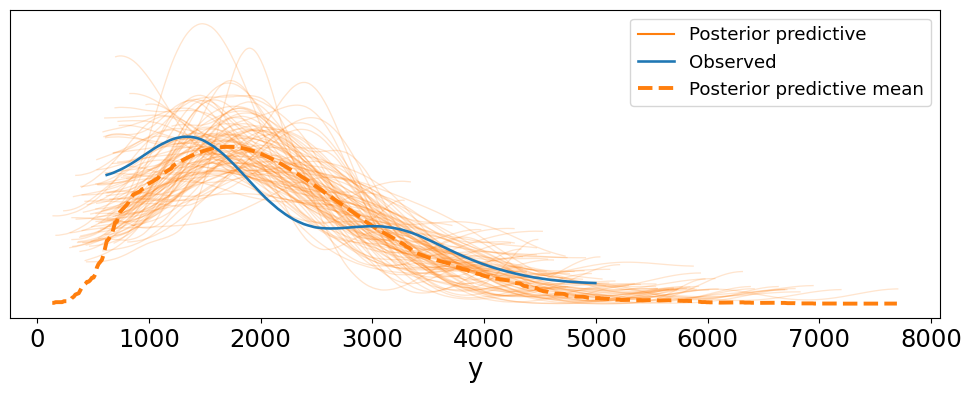

In [ ]:
pm.sample_posterior_predictive(idata_FluData_g, model= Flu_cases_model_Gamma, extend_inferencedata=True)
az.plot_ppc(idata_FluData_g, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

**Analyzation**

As you can see, this model works the best. The PPM line is much more similar to the observed data line. I think this is primarily due to the fact that I used a Gamma likelihood.

**________________________________________________________________________________________**

**Results**

I have determined that the true amount of people who contract influenza per week in Travis County is around ***1541*** people. This is mostly centered around the time period of November to March. Using this information hospitals can decide how much medication and other specific supplies they need to have on hand to combat this year's flu season.


**References**

https://www.dshs.texas.gov/sites/default/files/IDCU/disease/respiratory_virus_surveillance/2024/2024Week41TRVS-Final-pubOct18.pdf

https://www.cdc.gov/flu/index.html